# Disorder-induced two-body localised state in interacting quantum walks

L. A. Toikka

We investigate a discrete time quantum walk (Hadamard coin) with noisy interaction.

http://arxiv.org/abs/1911.06246

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
from sys import exit
import matplotlib.colors as colors




flatten = lambda l: [item for sublist in l for item in sublist];
bvecU = np.array([1,0]); 
bvecL = np.array([0,1]);
PLOT_x1 = 1;
PLOT_x1s1 = 2;
PLOT_s2 = 4;
PLOT_x2 = 8;
PLOT_s1 = 16;
PLOT_all = 1+2+4+8+16;


def setfont(size):
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : size};
    mpl.rc('font', **font);


def Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p):
    global NRmatdim;
    global bvecR;
    global matS2;
    global state2bodyT0;
    
    NRmatdim = NR - 1;
    bvecR = np.arange(1,NR);
    matRight = sparse.spdiags([1]*(NRmatdim -1),-1,NRmatdim ,NRmatdim );
    matLeft = sparse.spdiags([1]*(NRmatdim -1),1,NRmatdim ,NRmatdim ); 
    matNRId = sparse.identity(NRmatdim);
    matLL = sparse.csr_matrix(np.outer(bvecL,bvecL));
    matUU = sparse.csr_matrix(np.outer(bvecU,bvecU));
    matHad = sparse.csr_matrix(np.array([[np.sqrt(rho),np.sqrt(1-rho)],[np.sqrt(1-rho),-np.sqrt(rho)]]));
    matG = sparse.kron(matRight, matLL) + sparse.kron(matLeft, matUU);
    matS = sparse.csr_matrix(matG.dot(sparse.kron(matNRId, matHad)));

    def CreateBoperV2(p1):
        res = [];
        if (p1 == 1):     
            for i2 in range(NRmatdim): res = \
                np.concatenate((res, ([0, 0]*i2 + [1, 1] + [0, 0]*(NRmatdim - (i2 + 1)))*2));
        elif (p1 == 2):
            for i2 in range(NRmatdim): res = \
                np.concatenate((res, ([0, 0]*(i2-2) + [1, 1, 1, 1, 1, 1, 1, 1] + [0, 0]*(NRmatdim - (i2 + 3)))*2));
        elif (p1 == 3): 
            for i2 in range(NRmatdim):
                res = \
                np.concatenate((res, ([0, 0]*i2 + [np.exp(1j*mu)-1.0, 0] + [0, 0]*(NRmatdim - (i2 + 1)))));
                res = \
                np.concatenate((res, ([0, 0]*i2 + [0, np.exp(-1j*mu)-1.0] + [0, 0]*(NRmatdim - (i2 + 1)))));
        elif (p1 == 4): 
            for i2 in range(NRmatdim):
                res = \
                np.concatenate((res, ([0, 0]*i2 + [1, 0] + [0, 0]*(NRmatdim - (i2 + 1)))));
                res = \
                np.concatenate((res, ([0, 0]*i2 + [0, 1] + [0, 0]*(NRmatdim - (i2 + 1)))));                
                


        res = sparse.spdiags(res,0,4*NRmatdim**2,4*NRmatdim**2);
        if not ( p1 == 3): res = (np.exp(1j*mu)-1.0)*res;
        return res;
    


    matS2 = sparse.kron(matS, matS);
    matV2 = sparse.identity(4*NRmatdim**2) + CreateBoperV2(p);
    matS2 = sparse.csr_matrix(matV2.dot(matS2));


    vecC1T0 = np.eye(NRmatdim)[:,int(NRmatdim/2)-int(d0)];
    vecC2T0 = np.eye(NRmatdim)[:,int(NRmatdim/2)+int(d0)]; 
    


    state1T0 = np.kron(vecC1T0,vec1T0);
    state2T0 = np.kron(vecC2T0,vec2T0);
    state2bodyT0 = np.kron(state2T0, state1T0);

    return;

def Propagate2body(T,sT0):
    if (T == 0): s = sT0;
    else:
        s = matS2.dot(sT0);
        for _ in range(T-1):
            s = matS2.dot(s);
    return s;

def State2Prob(s):
    state2body = [np.abs(i2)**2 for i2 in s];

    state2body_NR = np.array(state2body[::2]) + np.array(state2body[1::2]); 
    
    tempres = [[np.sum(state2body_NR[i2:NRmatdim+1+i2:NRmatdim]) for i2 in range(NRmatdim)]]; 
    for i3 in np.arange(2,2*NRmatdim,2): 
        tempres.append([np.sum(state2body_NR[i3*NRmatdim+1+i2:(i3+2)*NRmatdim+1+i2:NRmatdim]) for i2 in range(NRmatdim)]);
 
    state2body_NR = flatten(tempres);
    return state2body_NR;



def Evaluate_entanglement(s,p):
    if (p == 1):
        s = s.reshape((4*NRmatdim, NRmatdim),order='F');
    elif (p == 2):
        s = s.reshape((2*NRmatdim, 2*NRmatdim),order='C');
    elif (p == 3):
        s = s.reshape((2*NRmatdim**2, 2),order='C');
    elif (p == 4):
        t2 = [];
        for i2 in range(2*NRmatdim): t2 = np.concatenate((t2, s[i2::2*NRmatdim] ));       
        s = t2.reshape(4*NRmatdim, NRmatdim, order='F');
    elif (p == 5):
        t2 = [];
        for i2 in range(2*NRmatdim): t2 = np.concatenate((t2, s[i2*4*NRmatdim:i2*4*NRmatdim+2*NRmatdim] ));
        for i2 in range(2*NRmatdim): t2 = np.concatenate((t2, s[i2*4*NRmatdim + 2*NRmatdim:(i2+1)*4*NRmatdim] ));
        s = t2.reshape(2*NRmatdim**2,2, order='F');

    u, s1, vh = np.linalg.svd(s, full_matrices=False);
    return -np.sum([i2**2 * np.log2(i2**2) if (i2 > 0) else 0 for i2 in s1]);


def UpdateInteraction(args=()):
    (NR,rho,d0,mu,vec1T0,vec2T0,Tmax,p,p3) = args;
    if (p3 == -1): return;
    elif (p3 == 1):
        mu = np.random.uniform(0.0, 2.0*np.pi);
    elif (p3 == 2): 
        mu = -mu;
    elif (p3 == 3): 
        dperc = 0.20;
        mu = np.random.uniform((1.0-dperc)*3.0*np.pi/2.0, (1.0+dperc)*3.0*np.pi/2.0);       
    elif (p3 == 4): 
        dperc = 0.15;
        mu = 0*3.0*np.pi/4.0 + np.random.uniform(-dperc*2.0*np.pi, dperc*2.0*np.pi); 
    elif (p3 == 5): 
        mu = 3.0*np.pi/2.0 + np.random.uniform(-np.pi/30.0, np.pi/30.0); 
    elif (p3 == 6):
        mu = 3.0*np.pi/2.0 + np.random.uniform(-np.pi/6.0, np.pi/6.0);        
    elif (p3 == 7): 
        mu = 3.0*np.pi/2.0 + np.random.uniform(-np.pi/2.0, np.pi/2.0);        
 
    Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p); 
 

def Plot2D_Density_antidiagonal(Tlist, strfig,args=()):
    (NR,rho,d0,mu,vec1T0,vec2T0,Tmax,p,p3) = args;
    Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p);

    
    i = 1;
    fig = plt.figure(figsize=(15,6)); plt.subplots_adjust(hspace=0.35); width = depth = 1;
    for T in Tlist:
        if (T == 0):
            state2body = state2bodyT0;
        else:
            state2body = matS2.dot(state2bodyT0);
            for _ in range(T-1): 
                state2body = matS2.dot(state2body);
                UpdateInteraction(args);

        state2body_NR = State2Prob(state2body);
        arr_s = np.array(state2body_NR);
        arr_s_antidiag = arr_s[1::NRmatdim+1];
                
        ax2 = fig.add_subplot(int(strfig + str(i)));
        i += 1;

        ax2.set_yscale('log');
        plt.plot(arr_s_antidiag[np.int((NR-3)/2)-50:np.int((NR-3)/2)+50], linestyle='', marker='v', color='g',alpha=0.7);
        loclength=2.886;
        expxmin=65; expxlength=10;
        expenv = [np.exp(-(i+35)/loclength) for i in range(expxlength)];
        plt.plot(np.arange(expxmin,expxmin+expxlength),expenv,linestyle='-', marker='', color='black',alpha=1.0);
        plt.xticks(np.arange(start=101,step=25),(-50,-25, 0, 25, 50));        
        plt.grid(); 
        plt.ylim(10**(-8),);
        plt.xlabel('$X$');
 
 
    plt.savefig("dens.pdf",format="pdf",bbox_inches='tight', pad_inches=0);
    plt.show();


        
    

def Plot2D_Density(Tlist, strfig,args=()):
    (NR,rho,d0,mu,vec1T0,vec2T0,Tmax,p,p3) = args;
    Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p);

    
    i = 1;
    pltx = flatten([bvecR]*NRmatdim);
    plty = flatten([[i2]*NRmatdim for i2 in bvecR]);
    fig = plt.figure(figsize=(15,6)); plt.subplots_adjust(hspace=0.35); width = depth = 1;
    for T in Tlist:
        if (T == 0):
            state2body = state2bodyT0;
        else:
            state2body = matS2.dot(state2bodyT0);
            for _ in range(T-1): 
                state2body = matS2.dot(state2body);
                UpdateInteraction(args);

        state2body_NR = State2Prob(state2body);
        arr_s = np.array(state2body_NR);

        ax2 = fig.add_subplot(int(strfig + str(i)));
        i += 1;
        ax2.set_xlim([-2+0.25/2,NR-2+0.25/2+0.5]);
        ax2.set_ylim([-1,NR-1+0.5]);

        #tickintval=10; vmin=0; vmax=1e-1; #for Fig. 1
        tickintval=50; vmin=1e-5; vmax=1e-2; #for Fig. 3
        cmap=colors.LinearSegmentedColormap.from_list('test', ['white', 'blue']);
        tmpfig = ax2.imshow(arr_s.reshape(NRmatdim, NRmatdim,order='C'),  \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', \
                            #vmin=vmin,vmax=vmax, cmap=cmap, \
                            interpolation='nearest');
        xmin, xmax = plt.xlim();
        ymin, ymax = plt.ylim();
        ax2.set_xticks(np.arange(xmin,xmax,tickintval), minor=False);
        ax2.set_yticks(np.arange(ymin,ymax,tickintval), minor=False);
        
        ax2.set_xticks(np.arange(xmin,xmax+1)-.5, minor=True);
        ax2.set_yticks(np.arange(ymin,ymax+1)-.5, minor=True);
        ax2.tick_params(which='minor',left=False, bottom=False, labeltop=False, labelbottom=True,labelleft=True);
        #ax2.grid(which="minor", color="m", linestyle='-', linewidth=1,alpha=0.1);
        ax2.grid(which="major", color="m", linestyle='--', linewidth=1,alpha=0.5);
        ax2.set_xticklabels(np.arange(np.int(-NR/2), np.int(NR/2+1),tickintval),minor=False);
        ax2.set_yticklabels(np.arange(np.int(-NR/2), np.int(NR/2+1),tickintval),minor=False);
        plt.xlabel('$X_1$');
        plt.ylabel('$X_2$'); 



    if (i==2): 
        fig.subplots_adjust(right=0.4);
        cbar_ax = fig.add_axes([0.42, 0.15, 0.01, 0.7]);    
    else:
        plt.ylabel('');
        fig.subplots_adjust(right=0.8);
        cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7]);

        
    fig.colorbar(tmpfig, cax=cbar_ax);    
    plt.savefig("dens.pdf",format="pdf",bbox_inches='tight', pad_inches=0);
    plt.show();


def Plot_entanglement(args,b,bool_Log=True):
    (NR,rho,d0,mu,vec1T0,vec2T0,Tmax,p,p3) = args;
    Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p);

    
    bool_plot_x1 = b & PLOT_x1;
    bool_plot_x1s1 = b & PLOT_x1s1;
    bool_plot_s2 = b & PLOT_s2;
    bool_plot_x2 = b & PLOT_x2;
    bool_plot_s1 = b & PLOT_s1;
    
    if (bool_plot_x1): array_ent1 = [Evaluate_entanglement(state2bodyT0,1)];
    if (bool_plot_x1s1): array_ent2 = [Evaluate_entanglement(state2bodyT0,2)];
    if (bool_plot_s2): array_ent3 = [Evaluate_entanglement(state2bodyT0,3)];
    if (bool_plot_x2): array_ent4 = [Evaluate_entanglement(state2bodyT0,4)];
    if (bool_plot_s1): array_ent5 = [Evaluate_entanglement(state2bodyT0,5)];
    state2body = state2bodyT0;

    for T in range(Tmax):
        if (Tmax > 0):
            state2body = matS2.dot(state2body);
            UpdateInteraction(args);
        
          
        if (bool_plot_x1): array_ent1.append(Evaluate_entanglement(state2body,1));
        if (bool_plot_x1s1): array_ent2.append(Evaluate_entanglement(state2body,2));
        if (bool_plot_s2): array_ent3.append(Evaluate_entanglement(state2body,3));
        if (bool_plot_x2): array_ent4.append(Evaluate_entanglement(state2body,4));
        if (bool_plot_s1): array_ent5.append(Evaluate_entanglement(state2body,5));


    plt.xlabel('Step');
    plt.ylabel('$S_A$'); 
    if (bool_Log):
        if (bool_plot_x1): plt.semilogx(array_ent1, linestyle='--', marker='v', color='b', label='$A = X_1$',alpha=0.7);
        if (bool_plot_x2): plt.semilogx(array_ent4, linestyle='--', marker='^', color='y', label='$A = X_2$',alpha=0.7); 
        if (bool_plot_s1): plt.semilogx(array_ent5, linestyle='--', marker='o', color='m', label='$A = \zeta_1$',alpha=0.7);
        if (bool_plot_s2): plt.semilogx(array_ent3, linestyle='--', marker='s', color='g', label='$A = \zeta_2$',alpha=0.7);
        if (bool_plot_x1s1): plt.semilogx(array_ent2, linestyle='--', marker='p', color='r', label='$A = \{ X_1, \zeta_1 \}$',alpha=0.7);
    else:
        if (bool_plot_x1): plt.plot(array_ent1, linestyle='--', marker='v', color='b', label='$A = X_1$',alpha=0.7);
        if (bool_plot_x2): plt.plot(array_ent4, linestyle='--', marker='^', color='y', label='$A = X_2$',alpha=0.7); 
        if (bool_plot_s1): plt.plot(array_ent5, linestyle='--', marker='o', color='m', label='$A = \zeta_1$',alpha=0.7);
        if (bool_plot_s2): plt.plot(array_ent3, linestyle='--', marker='s', color='g', label='$A = \zeta_2$',alpha=0.7);
        if (bool_plot_x1s1): plt.plot(array_ent2, linestyle='--', marker='p', color='r', label='$A = \{ X_1, \zeta_1 \}$',alpha=0.7);
    plt.grid();
    xmin, xmax = plt.xlim();
    #plt.xticks(np.arange(xmin+1, xmax,2)); #fig 1
    #plt.legend(loc='best',bbox_to_anchor=(0.07, 0.15),fontsize='small'); #fig 1
    #plt.legend(loc='best',fontsize='x-small'); #fig 2 and others.

        
    ymin, ymax = plt.ylim();
    plt.ylim(ymax=ymax+0.0);
    plt.savefig("ent.pdf",format="pdf",bbox_inches='tight', pad_inches=0);
    plt.show();
    


def Plot_entanglement_loglogx(args,b):
    (NR,rho,d0,mu,vec1T0,vec2T0,Tmax,p,p3) = args;
    Initialise(NR,rho,d0,mu,vec1T0,vec2T0,p);

    
    bool_plot_x1 = b & PLOT_x1;
    bool_plot_x1s1 = b & PLOT_x1s1;
    bool_plot_s2 = b & PLOT_s2;
    bool_plot_x2 = b & PLOT_x2;
    bool_plot_s1 = b & PLOT_s1;
    
    if (bool_plot_x1): array_ent1 = [Evaluate_entanglement(state2bodyT0,1)];
    if (bool_plot_x1s1): array_ent2 = [Evaluate_entanglement(state2bodyT0,2)];
    if (bool_plot_s2): array_ent3 = [Evaluate_entanglement(state2bodyT0,3)];
    if (bool_plot_x2): array_ent4 = [Evaluate_entanglement(state2bodyT0,4)];
    if (bool_plot_s1): array_ent5 = [Evaluate_entanglement(state2bodyT0,5)];
    state2body = state2bodyT0;

    x = np.arange(20,Tmax+1);

    for T in range(Tmax):
        if (Tmax > 0):
            state2body = matS2.dot(state2body);
            UpdateInteraction(args);
           
        if (bool_plot_x1): array_ent1.append(Evaluate_entanglement(state2body,1));
        if (bool_plot_x1s1): array_ent2.append(Evaluate_entanglement(state2body,2));
        if (bool_plot_s2): array_ent3.append(Evaluate_entanglement(state2body,3));
        if (bool_plot_x2): array_ent4.append(Evaluate_entanglement(state2body,4));
        if (bool_plot_s1): array_ent5.append(Evaluate_entanglement(state2body,5));


    plt.xlabel('Step');
    plt.ylabel('$S_A$'); 

    if (bool_plot_x1): plt.plot(x,array_ent1[20:], linestyle='--', marker='v', color='b', label='$A = X_1$',alpha=0.7);
    if (bool_plot_x2): plt.plot(x,array_ent4[20:], linestyle='--', marker='^', color='y', label='$A = X_2$',alpha=0.7); 
    if (bool_plot_s1): plt.plot(x,array_ent5[20:], linestyle='--', marker='o', color='m', label='$A = \zeta_1$',alpha=0.7);
    if (bool_plot_s2): plt.plot(x,array_ent3[20:], linestyle='--', marker='s', color='g', label='$A = \zeta_2$',alpha=0.7);
    if (bool_plot_x1s1): plt.plot(x,array_ent2[20:], linestyle='--', marker='p', color='r', label='$A = \{ X_1, \zeta_1 \}$',alpha=0.7);
    plt.grid();
    xmin, xmax = plt.xlim();

        

    def forward(x):
        return np.log(np.log(x));

    def inverse(x):
        return 10**(10**x);
    
    plt.xscale('function', functions=(forward, inverse));
    plt.xlim(20,Tmax+1);
    plt.xticks([25,50,100,250,500,1000]);
    

    ymin, ymax = plt.ylim();
    plt.ylim(ymax=ymax+0.0);
    plt.savefig("ent.pdf",format="pdf",bbox_inches='tight', pad_inches=0);
    plt.show();
    

## Fig. 1

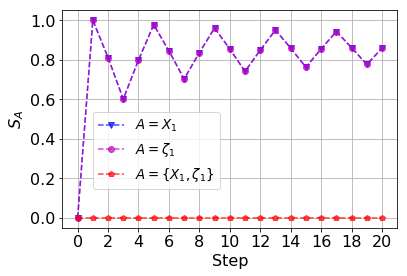

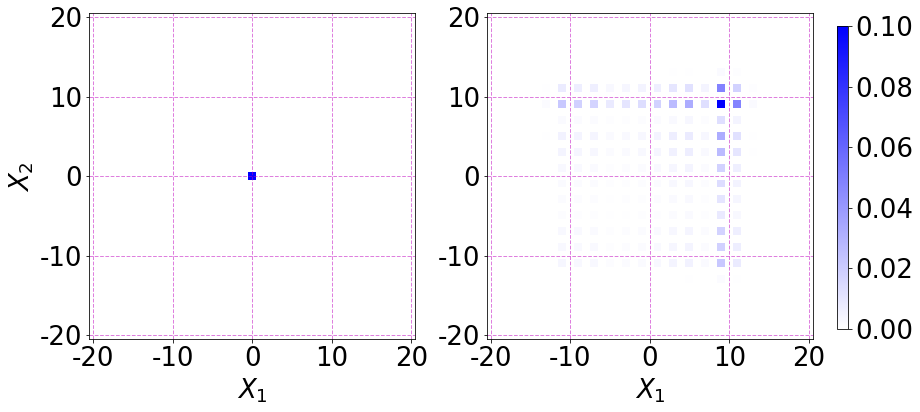

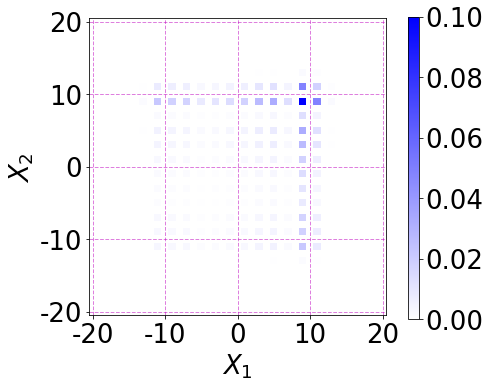

In [12]:
setfont(16);
params = (40, 1/2, 0, 0.0, bvecL, bvecL, 20, 1,-1);
Plot_entanglement(params,PLOT_x1+PLOT_x1s1+PLOT_s1,False);
setfont(26);
Plot2D_Density([0,15],'12', params);
Plot2D_Density([15],'11', params);

## Fig. 2

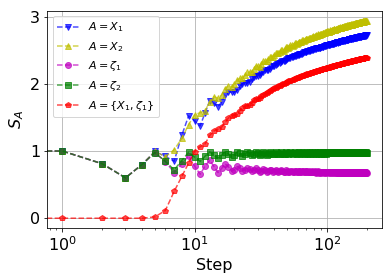

In [6]:
setfont(16);
params = (400, 1/2, 5, 3.0*np.pi/2.0, bvecL, bvecL,200,1,-1);
Plot_entanglement(params, PLOT_all);

## Fig. 3

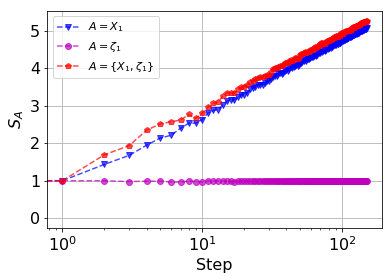

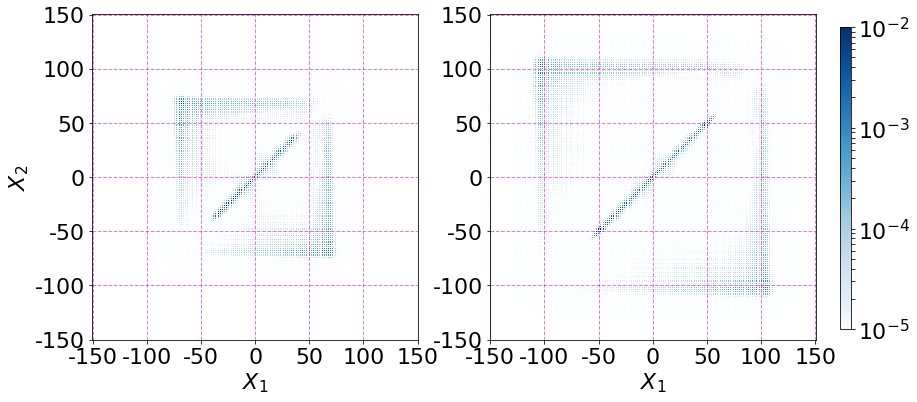

In [7]:
setfont(16);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecU, bvecU, 150, 1,-1);
Plot_entanglement(params, PLOT_x1+PLOT_s1+PLOT_x1s1);
setfont(22);
Plot2D_Density([100,150],'12',params); 

## Fig. 4

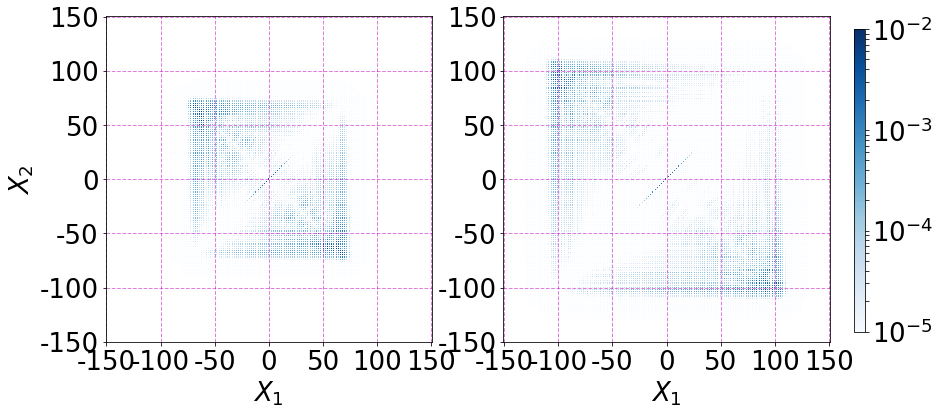

In [16]:
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,1);
Plot2D_Density([100,150],'12', params);

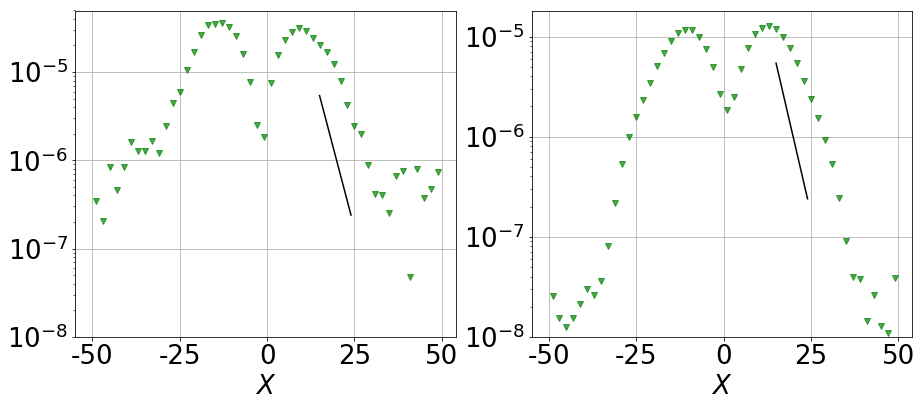

In [183]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,1);
Plot2D_Density_antidiagonal([100,150],'12', params);

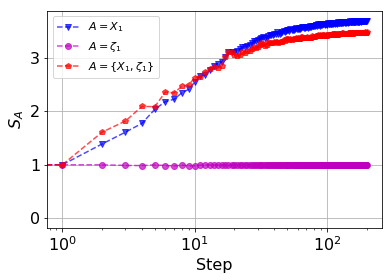

In [21]:
setfont(16);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,1);
Plot_entanglement(params,PLOT_x1+PLOT_x1s1+PLOT_s1);

## Fig. 5

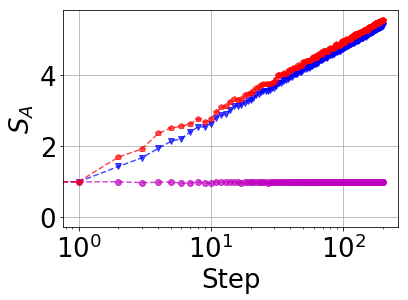

In [190]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,5);
Plot_entanglement(params,PLOT_x1+PLOT_x1s1+PLOT_s1);

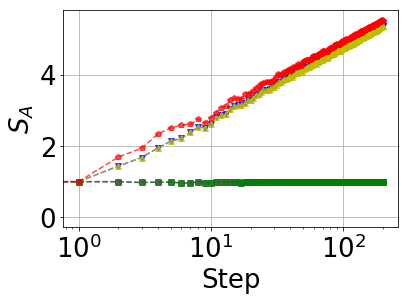

In [198]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,5);
Plot_entanglement(params,PLOT_all);

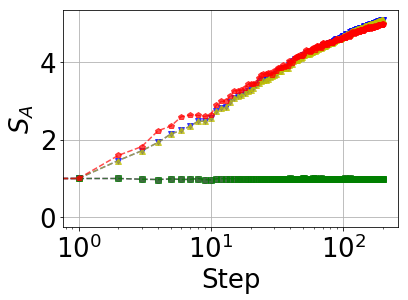

In [197]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,6);
Plot_entanglement(params,PLOT_all);

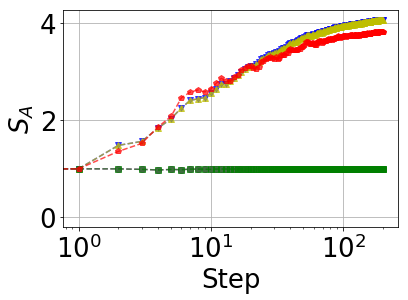

In [195]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,7);
Plot_entanglement(params,PLOT_all);

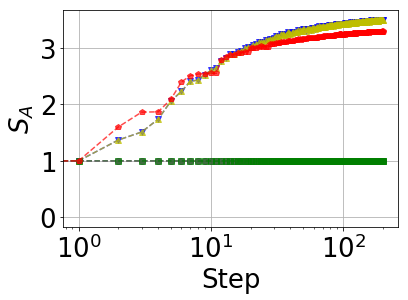

In [196]:
setfont(26);
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 1,1);
Plot_entanglement(params,PLOT_all);

## Fig. 6

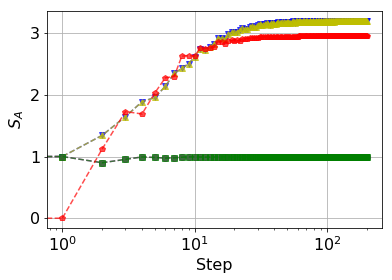

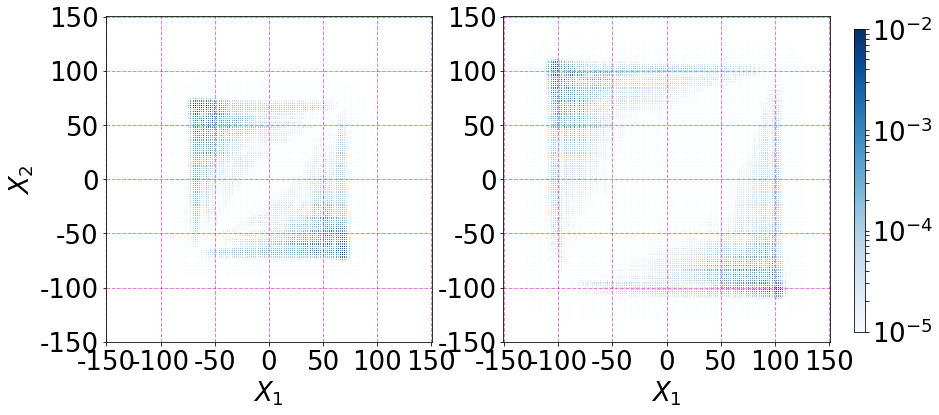

In [199]:
params = (300, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 200, 3, 1);
setfont(16);
Plot_entanglement(params,PLOT_all);
setfont(26);
Plot2D_Density([100,150],'12', params);

## Fig. 7

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: invalid value encountered in log
posx and posy should be finite values
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:543: RuntimeWarning: invalid value encountered in log


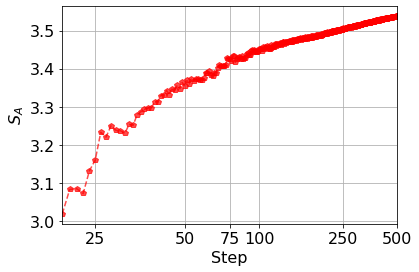

In [16]:
setfont(16);
params = (800, 1/2, 0, 3.0*np.pi/2.0, bvecL, bvecL, 500, 1,1);
Plot_entanglement_loglogx(params,PLOT_x1s1);